In [160]:
import owlready2
import networkx as nx
from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.utils import from_networkx
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch.optim as optim
import copy
from memory_profiler import profile

In [161]:
# Step 1: Load Ontologies
def load_ontology(ontology_path):
    onto = owlready2.get_ontology(ontology_path).load()
    return onto

In [209]:
itsmo_ontology = load_ontology('/Users/andreykhalov/HULK/PHD/MFTI/VKR/diser/upper_ontology/DLP3971/ITSMO.owl')
dolce_ontology = load_ontology('/Users/andreykhalov/HULK/PHD/MFTI/VKR/diser/upper_ontology/DLP3971/DLP_merged.rdf')

In [163]:
itsmo_ontology

get_ontology("http://ontology.it/itsmo/v1#")

In [220]:
def ontology_to_graph(onto):
    G = nx.DiGraph()
    node_mapping = {}
    index = 0
    # Добавление классов в граф
    for cls in onto.classes():
        G.add_node(cls.name, type='class')  # Добавление типа узла
        node_mapping[index] = cls.name
        # Добавление отношений подклассов
        for parent in cls.is_a:
            if isinstance(parent, owlready2.entity.ThingClass):
                G.add_edge(cls.name, parent.name, relation='is_a')
        index += 1
    # Добавление объектных свойств в граф
    for prop in onto.object_properties():
        G.add_node(prop.name, type='property')  # Добавление типа узла
        # Добавление доменных и диапазонных отношений как рёбер
        for domain in prop.domain:
            domain_names = get_class_names(domain)
            for domain_name in domain_names:
                G.add_edge(prop.name, domain_name, relation='has_domain')
        for range_ in prop.range:
            range_names = get_class_names(range_)
            for range_name in range_names:
                G.add_edge(prop.name, range_name, relation='has_range')
                # Добавляем связь от домена к диапазону через свойство
                for domain_name in domain_names:
                    G.add_edge(domain_name, range_name, relation=prop.name)
    # Добавление индивидов в граф
    for individual in onto.individuals():
        G.add_node(individual.name, type='individual')  # Добавление типа узла
        # Добавление отношений индивидов к их классам
        for cls in individual.is_a:
            if isinstance(cls, owlready2.entity.ThingClass):
                G.add_edge(individual.name, cls.name, relation='instance_of')
    
    return G, node_mapping

In [216]:
def get_class_names(class_expression):
    if isinstance(class_expression, owlready2.entity.ThingClass):
        return [class_expression.name]
    elif isinstance(class_expression, owlready2.class_construct.LogicalClassConstruct):
        names = []
        for operand in class_expression.Classes:
            names.extend(get_class_names(operand))
        return names
    elif isinstance(class_expression, owlready2.class_construct.Restriction):
        return get_class_names(class_expression.value)
    else:
        return []

In [212]:
def remove_isolated_nodes(G):
    # Удаление изолированных узлов (узлов со степенью 0)
    isolated_nodes = [node for node, degree in G.degree() if degree == 0]
    G.remove_nodes_from(isolated_nodes)
    print(f"Удалено изолированных узлов: {len(isolated_nodes)}")
    return G

In [ ]:
itsmo_graph, itsmo_node_mapping = ontology_to_graph(itsmo_ontology)
dolce_graph, dolce_node_mapping = ontology_to_graph(dolce_ontology)

# Применяем фильтрацию
itsmo_graph_filter = remove_isolated_nodes(itsmo_graph)
dolce_graph_filter = remove_isolated_nodes(dolce_graph)

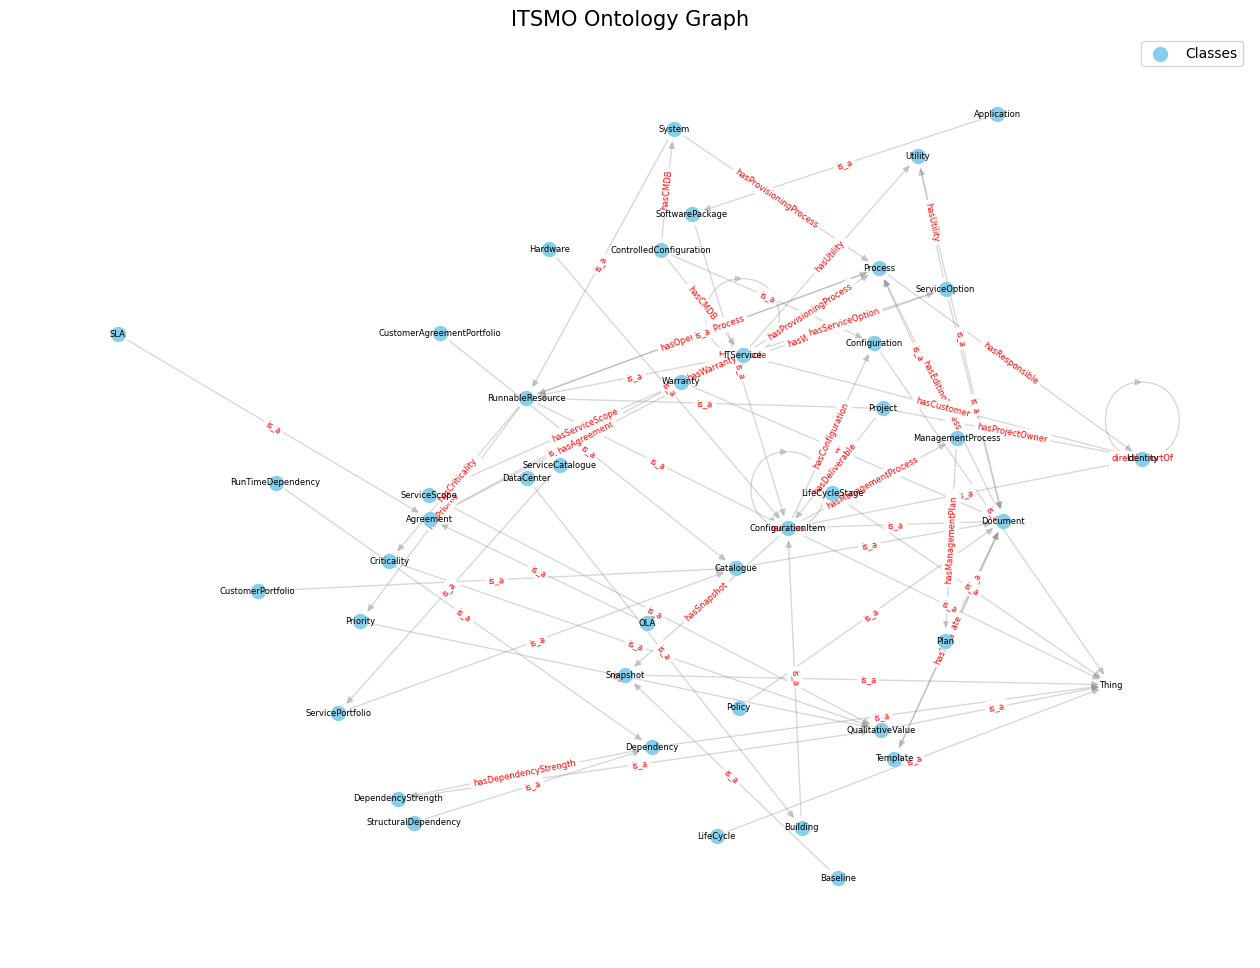

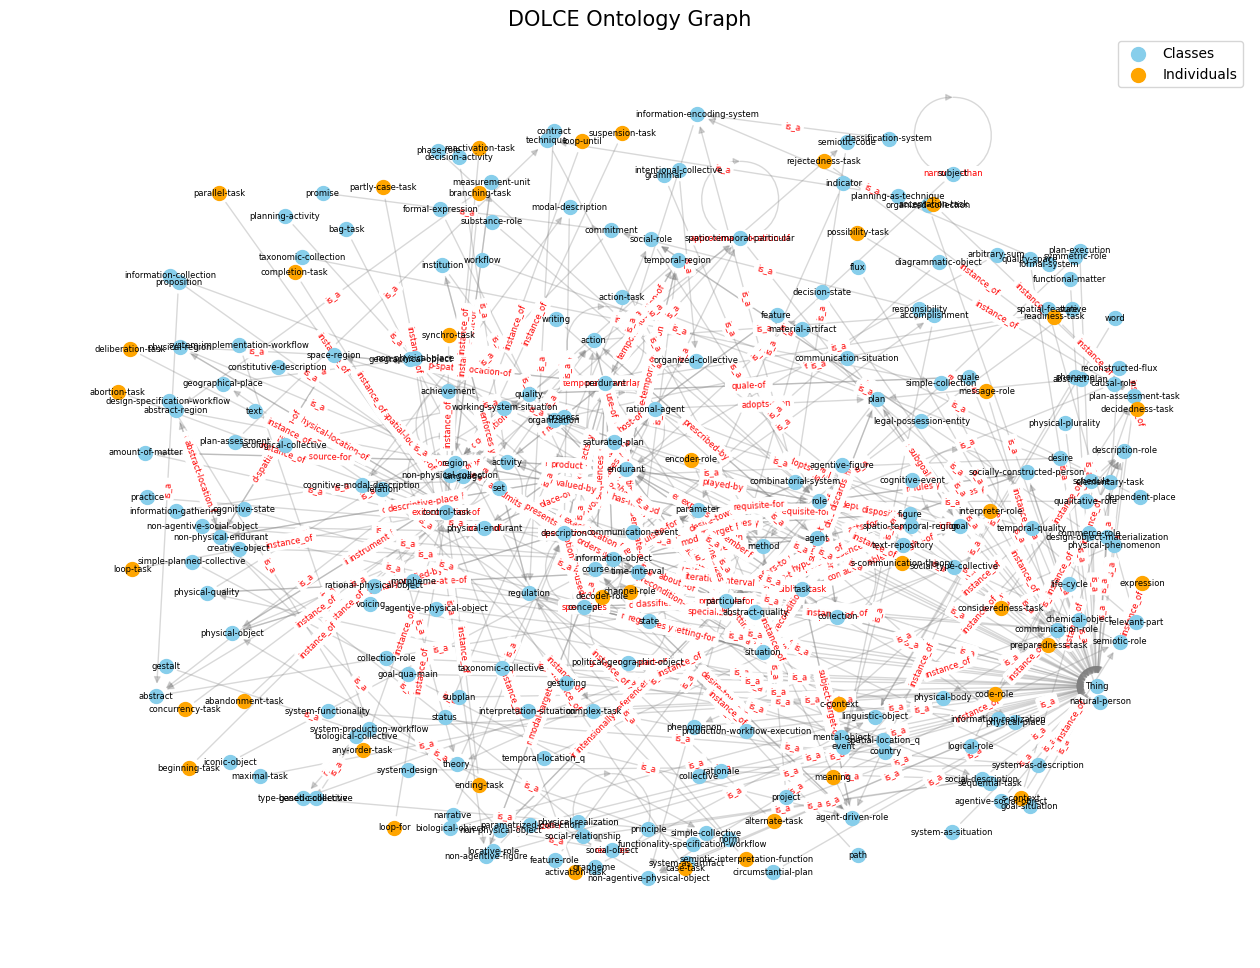

In [221]:
# Функция для визуализации графа с разными цветами для разных типов узлов

def visualize_graph(G, title, k=0.3, iterations=20):
    plt.figure(figsize=(16, 12))
    
    # Определение положения узлов с использованием spring layout
    pos = nx.spring_layout(G, k=k, iterations=iterations)
    
    # Разделение узлов по типам
    class_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'class']
    individual_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'individual']
    property_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'property']
    
    # Рисование узлов разных типов разными цветами
    if class_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=class_nodes, node_color='skyblue', label='Classes', node_size=100)
    if individual_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=individual_nodes, node_color='orange', label='Individuals', node_size=100)
    if property_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=property_nodes, node_color='lightgreen', label='Properties', node_size=100)
    
    # Рисование рёбер и подписей
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')
    
    # Добавление подписей для рёбер (отношений)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color='red')
    
    # Добавление легенды
    plt.legend(scatterpoints=1, fontsize=10)
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

visualize_graph(itsmo_graph_filter, "ITSMO Ontology Graph")
visualize_graph(dolce_graph_filter, "DOLCE Ontology Graph")

In [222]:
# Функция для проверки, что все элементы онтологии добавлены в граф

def validate_graph_elements(onto, G):
    # Подсчёт классов, свойств и индивидов в онтологии
    class_count = len(list(onto.classes()))
    property_count = len(list(onto.object_properties()))
    individual_count = len(list(onto.individuals()))

    # Подсчёт узлов и рёбер в графе
    class_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'class']
    property_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'property']
    individual_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'individual']

    # Сравнение количества узлов и рёбер с количеством элементов онтологии
    print(f"Классы в онтологии: {class_count}, Классы в графе: {len(class_nodes)}")
    print(f"Свойства в онтологии: {property_count}, Свойства в графе: {len(property_nodes)}")
    print(f"Индивиды в онтологии: {individual_count}, Индивиды в графе: {len(individual_nodes)}")

    if class_count == len(class_nodes):
        print("Все классы добавлены в граф.")
    else:
        print("Некоторые классы не были добавлены в граф.")

    if property_count == len(property_nodes):
        print("Все свойства добавлены в граф.")
    else:
        print("Некоторые свойства не были добавлены в граф.")

    if individual_count == len(individual_nodes):
        print("Все индивиды добавлены в граф.")
    else:
        print("Некоторые индивиды не были добавлены в граф.")


G, node_mapping = ontology_to_graph(itsmo_ontology)
validate_graph_elements(itsmo_ontology, G)


Классы в онтологии: 42, Классы в графе: 42
Свойства в онтологии: 41, Свойства в графе: 41
Индивиды в онтологии: 0, Индивиды в графе: 0
Все классы добавлены в граф.
Все свойства добавлены в граф.
Все индивиды добавлены в граф.


In [249]:
# Step 3: Generate Random Walk Embeddings
def generate_embeddings(G):
    node2vec = Node2Vec(G, dimensions=256, walk_length=10, num_walks=10000, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model

itsmo_embeddings_model = generate_embeddings(itsmo_graph)
dolce_embeddings_model = generate_embeddings(dolce_graph)

Computing transition probabilities:   0%|          | 0/43 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2500/2500 [00:00<00:00, 3554.04it/s]


Computing transition probabilities:   0%|          | 0/247 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2500/2500 [00:04<00:00, 504.22it/s]


In [244]:
# Step 4: Compute Similarities
def compute_similarity(itsmo_model, dolce_model):
    itsmo_nodes = list(itsmo_model.wv.index_to_key)
    dolce_nodes = list(dolce_model.wv.index_to_key)
    
    itsmo_vectors = [itsmo_model.wv[node] for node in itsmo_nodes]
    dolce_vectors = [dolce_model.wv[node] for node in dolce_nodes]
    
    # Normalize vectors
    itsmo_vectors = np.array(itsmo_vectors)
    dolce_vectors = np.array(dolce_vectors)
    
    similarities = cosine_similarity(itsmo_vectors, dolce_vectors)
    return itsmo_nodes, dolce_nodes, similarities

itsmo_nodes, dolce_nodes, similarities = compute_similarity(itsmo_embeddings_model, dolce_embeddings_model)

In [245]:
def find_mappings(itsmo_nodes, dolce_nodes, similarities, threshold=0.0):
    mappings = []
    similarity_scores = []  # Collect similarity scores
    for i, itsmo_node in enumerate(itsmo_nodes):
        for j, dolce_node in enumerate(dolce_nodes):
            sim = similarities[i][j]
            if sim > threshold:
                mappings.append((itsmo_node, dolce_node, sim))
                similarity_scores.append(sim)
    return mappings, similarity_scores

mappings, similarity_scores_node2vec = find_mappings(itsmo_nodes, dolce_nodes, similarities)

In [246]:
# Output mappings
for mapping in mappings:
    if mapping[2] > 0.0:
        print(f"ITSMO Entity: {mapping[0]} <--> DOLCE Entity: {mapping[1]} | Similarity: {mapping[2]:.2f}")

ITSMO Entity: Thing <--> DOLCE Entity: endurant | Similarity: 0.03
ITSMO Entity: Thing <--> DOLCE Entity: particular | Similarity: 0.02
ITSMO Entity: Thing <--> DOLCE Entity: region | Similarity: 0.11
ITSMO Entity: Thing <--> DOLCE Entity: perdurant | Similarity: 0.03
ITSMO Entity: Thing <--> DOLCE Entity: physical-endurant | Similarity: 0.04
ITSMO Entity: Thing <--> DOLCE Entity: information-object | Similarity: 0.15
ITSMO Entity: Thing <--> DOLCE Entity: spatio-temporal-particular | Similarity: 0.05
ITSMO Entity: Thing <--> DOLCE Entity: non-physical-object | Similarity: 0.05
ITSMO Entity: Thing <--> DOLCE Entity: non-physical-endurant | Similarity: 0.05
ITSMO Entity: Thing <--> DOLCE Entity: space-region | Similarity: 0.03
ITSMO Entity: Thing <--> DOLCE Entity: figure | Similarity: 0.05
ITSMO Entity: Thing <--> DOLCE Entity: agent | Similarity: 0.15
ITSMO Entity: Thing <--> DOLCE Entity: control-task | Similarity: 0.10
ITSMO Entity: Thing <--> DOLCE Entity: physical-region | Similar

In [247]:
def plot_similarity_distribution(similarity_scores, name):
    plt.figure(figsize=(8, 6))
    sns.histplot(similarity_scores, bins=100, kde=True, color='blue', alpha=0.6)
    plt.title(f"Distribution of Similarity Scores {name}", fontsize=16)
    plt.xlabel("Similarity Score", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

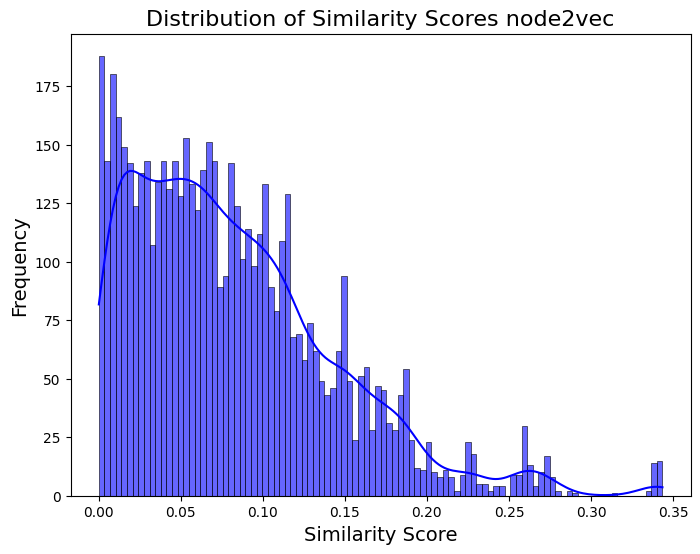

In [248]:
plot_similarity_distribution(similarity_scores_node2vec, 'node2vec')

### Теперь графовая нейросеть

In [240]:
def convert_to_pyg_data(G):
    # Convert a NetworkX graph to PyTorch Geometric data format
    data = from_networkx(G)
    return data

# Convert ITSMO and DOLCE graphs to PyTorch Geometric format
itsmo_data = convert_to_pyg_data(itsmo_graph)
dolce_data = convert_to_pyg_data(dolce_graph)

ValueError: Not all nodes contain the same attributes

In [16]:
class GraphSAGEWithProjection(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, projection_size):
        super(GraphSAGEWithProjection, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.projection = torch.nn.Linear(out_channels, projection_size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.projection(x)
        return x

model = GraphSAGEWithProjection(in_channels=32, hidden_channels=64, out_channels=64, projection_size=32)

In [17]:
def add_node_features(data, num_features=32):
    num_nodes = data.num_nodes
    if data.x is None:
        data.x = torch.rand(num_nodes, num_features)
    return data

itsmo_data = add_node_features(itsmo_data, num_features=32)
dolce_data = add_node_features(dolce_data, num_features=32)

In [18]:
print("ITSMO Data:", itsmo_data)
print("DOLCE Data:", dolce_data)

# Check the node features
print("ITSMO Node Features:", itsmo_data.x)
print("DOLCE Node Features:", dolce_data.x)

ITSMO Data: Data(edge_index=[2, 109], num_nodes=81, x=[81, 32])
DOLCE Data: Data(edge_index=[2, 776], num_nodes=519, x=[519, 32])
ITSMO Node Features: tensor([[0.3333, 0.1540, 0.2759,  ..., 0.2993, 0.5217, 0.8952],
        [0.9172, 0.6052, 0.8403,  ..., 0.3692, 0.5403, 0.3367],
        [0.3846, 0.1253, 0.9720,  ..., 0.6312, 0.8008, 0.2471],
        ...,
        [0.5107, 0.2331, 0.1676,  ..., 0.2822, 0.7310, 0.1975],
        [0.1273, 0.7445, 0.4570,  ..., 0.7245, 0.2526, 0.9370],
        [0.0185, 0.5450, 0.2134,  ..., 0.9764, 0.3197, 0.0101]])
DOLCE Node Features: tensor([[0.0493, 0.7966, 0.1849,  ..., 0.2202, 0.6105, 0.9198],
        [0.8025, 0.0581, 0.4904,  ..., 0.0347, 0.1250, 0.0623],
        [0.4312, 0.4152, 0.2585,  ..., 0.0533, 0.3036, 0.9825],
        ...,
        [0.3837, 0.2500, 0.2960,  ..., 0.4756, 0.9713, 0.4435],
        [0.6608, 0.7862, 0.9987,  ..., 0.4526, 0.1378, 0.9819],
        [0.9984, 0.9075, 0.9835,  ..., 0.9641, 0.9043, 0.4970]])


In [19]:
# Initialize the model, optimizer, and loss function
in_channels = 32  # The size of the input features (e.g., 64)
hidden_channels = 128  # The size of the hidden layer
out_channels = 32  # The size of the final embedding

optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss()

# Training function
def train(data, model, optimizer, epochs=20000):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return model, losses

trained_model_itsmo, itsmo_losses = train(itsmo_data, model, optimizer)
trained_model_dolce, dolce_losses = train(dolce_data, model, optimizer)

Epoch 0, Loss: 0.38915905356407166
Epoch 50, Loss: 0.37698522210121155
Epoch 100, Loss: 0.3653756082057953
Epoch 150, Loss: 0.3540346920490265
Epoch 200, Loss: 0.3427329957485199
Epoch 250, Loss: 0.3312855362892151
Epoch 300, Loss: 0.31963521242141724
Epoch 350, Loss: 0.30772438645362854
Epoch 400, Loss: 0.2955388128757477
Epoch 450, Loss: 0.28307291865348816
Epoch 500, Loss: 0.27036237716674805
Epoch 550, Loss: 0.257493257522583
Epoch 600, Loss: 0.24455440044403076
Epoch 650, Loss: 0.23173433542251587
Epoch 700, Loss: 0.2192356139421463
Epoch 750, Loss: 0.20720550417900085
Epoch 800, Loss: 0.19574499130249023
Epoch 850, Loss: 0.18496638536453247
Epoch 900, Loss: 0.1750408411026001
Epoch 950, Loss: 0.16597704589366913
Epoch 1000, Loss: 0.1577356904745102
Epoch 1050, Loss: 0.15025247633457184
Epoch 1100, Loss: 0.14345109462738037
Epoch 1150, Loss: 0.13726568222045898
Epoch 1200, Loss: 0.1316245049238205
Epoch 1250, Loss: 0.12645818293094635
Epoch 1300, Loss: 0.12171875685453415
Epoch 13

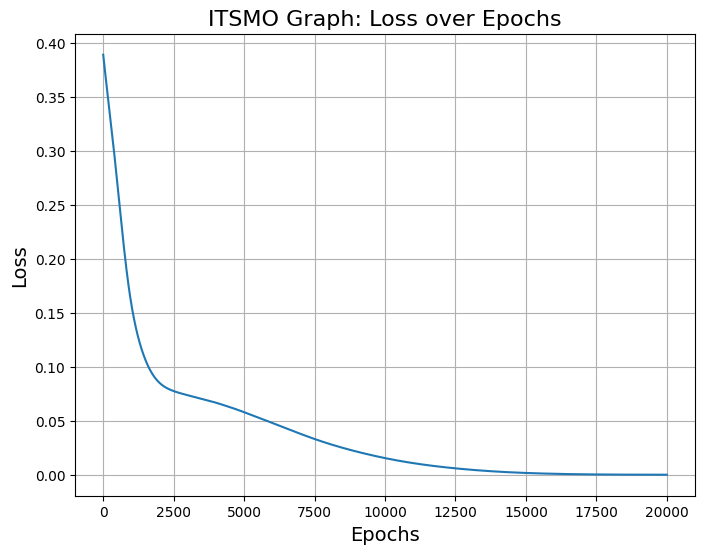

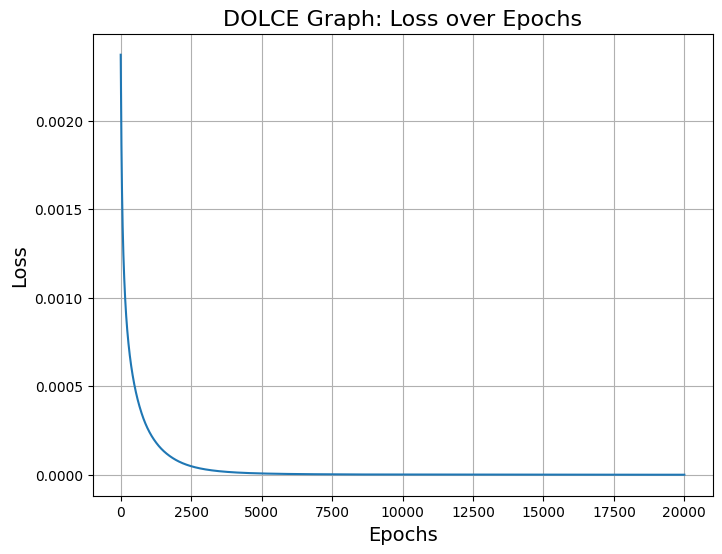

In [20]:
# Function to plot the loss
def plot_loss(losses, title):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(losses)), losses, label='Loss')
    plt.title(f"{title}: Loss over Epochs", fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid(True)
    plt.show()

# Plot the losses for ITSMO
plot_loss(itsmo_losses, "ITSMO Graph")

# Plot the losses for DOLCE
plot_loss(dolce_losses, "DOLCE Graph")

In [21]:
def get_node_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model(data)
    return embeddings

itsmo_embeddings = get_node_embeddings(trained_model_itsmo, itsmo_data)
dolce_embeddings = get_node_embeddings(trained_model_dolce, dolce_data)

In [22]:
def compute_gnn_similarity(itsmo_embeddings, dolce_embeddings):
    # Преобразуем тензоры PyTorch в numpy массивы для вычисления сходства
    itsmo_vectors = itsmo_embeddings.cpu().numpy()
    dolce_vectors = dolce_embeddings.cpu().numpy()
    
    # Вычисляем косинусное сходство между векторами ITSMO и DOLCE
    similarities = cosine_similarity(itsmo_vectors, dolce_vectors)
    return similarities

# Вычисляем сходства
similarities = compute_gnn_similarity(itsmo_embeddings, dolce_embeddings)

In [57]:
def find_mappings_by_index(itsmo_data, dolce_data, similarities, threshold=0.0):
    num_itsmo_nodes = itsmo_data.num_nodes
    num_dolce_nodes = dolce_data.num_nodes

    mappings = []
    similarity_scores = []  # Сохраняем значения сходства
    for i in range(num_itsmo_nodes):
        for j in range(num_dolce_nodes):
            sim = similarities[i][j]
            if sim > threshold:
                mappings.append((i, j, sim))  # Используем индексы узлов вместо ID
                similarity_scores.append(sim)
    return mappings, similarity_scores

# Получаем маппинги на основе индексов
mappings, similarity_scores = find_mappings_by_index(itsmo_data, dolce_data, similarities)

# Печать результатов маппинга с использованием индексов узлов
for mapping in mappings:
    print(f"ITSMO Node Index: {mapping[0]} <--> DOLCE Node Index: {mapping[1]} | Similarity: {mapping[2]:.2f}")

ITSMO Node Index: 0 <--> DOLCE Node Index: 0 | Similarity: 0.68
ITSMO Node Index: 0 <--> DOLCE Node Index: 1 | Similarity: 0.80
ITSMO Node Index: 0 <--> DOLCE Node Index: 2 | Similarity: 0.70
ITSMO Node Index: 0 <--> DOLCE Node Index: 3 | Similarity: 0.77
ITSMO Node Index: 0 <--> DOLCE Node Index: 4 | Similarity: 0.69
ITSMO Node Index: 0 <--> DOLCE Node Index: 5 | Similarity: 0.76
ITSMO Node Index: 0 <--> DOLCE Node Index: 6 | Similarity: 0.73
ITSMO Node Index: 0 <--> DOLCE Node Index: 7 | Similarity: 0.80
ITSMO Node Index: 0 <--> DOLCE Node Index: 8 | Similarity: 0.77
ITSMO Node Index: 0 <--> DOLCE Node Index: 9 | Similarity: 0.74
ITSMO Node Index: 0 <--> DOLCE Node Index: 10 | Similarity: 0.75
ITSMO Node Index: 0 <--> DOLCE Node Index: 11 | Similarity: 0.76
ITSMO Node Index: 0 <--> DOLCE Node Index: 12 | Similarity: 0.69
ITSMO Node Index: 0 <--> DOLCE Node Index: 13 | Similarity: 0.73
ITSMO Node Index: 0 <--> DOLCE Node Index: 14 | Similarity: 0.80
ITSMO Node Index: 0 <--> DOLCE Node

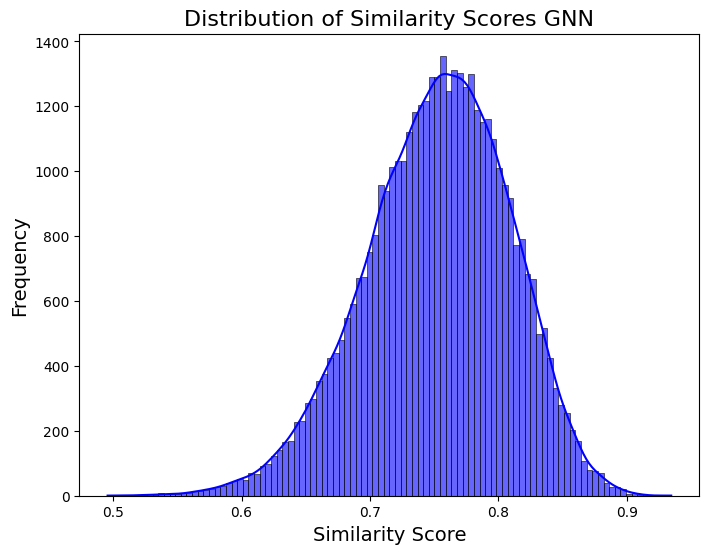

In [58]:
plot_similarity_distribution(similarity_scores, 'GNN')

In [59]:
# Определяем функцию для обработки логических выражений
def process_logical_expression(expression, dolce_classes, dolce_ontology):
    classes = []
    for operand in expression.Classes:
        if operand.name not in dolce_classes:
            with dolce_ontology:
                new_class = owlready2.types.new_class(operand.name, (owlready2.Thing,))
            dolce_classes.add(operand.name)
        else:
            new_class = dolce_ontology[operand.name]
        classes.append(new_class)
    return classes

In [60]:
# Функция для создания новой пустой онтологии
def create_new_ontology(new_ontology_uri="http://newdolce.owl"):
    # Создаем новую пустую онтологию с указанным URI
    new_ontology = owlready2.get_ontology(new_ontology_uri)
    return new_ontology

In [61]:
def transfer_itsmo_to_dolce(itsmo_ontology, dolce_ontology, itsmo_data, dolce_data, itsmo_embeddings, dolce_embeddings):
    # Создаем новую пустую онтологию для DOLCE
    dolce_ontology_copy = create_new_ontology()

    with dolce_ontology_copy:
        # Создание свойства для связи между ITSMO и DOLCE классами
        class isMappedTo(owlready2.ObjectProperty):
            domain = [owlready2.Thing]
            range = [owlready2.Thing]

    print("Начало переноса классов и свойств из ITSMO в новую DOLCE...")

    # Собираем все имена классов и свойств из DOLCE для быстрого поиска
    dolce_classes = {cls.name for cls in dolce_ontology.classes()}
    dolce_properties = {prop.name for prop in dolce_ontology.object_properties()}
    print(f"Классов в DOLCE: {len(dolce_classes)}, Свойств в DOLCE: {len(dolce_properties)}")

    # Шаг 1: Перенос классов ITSMO в DOLCE
    for idx, cls in enumerate(itsmo_ontology.classes()):
        print(f"[{idx+1}/{len(list(itsmo_ontology.classes()))}] Проверка класса: {cls.name}")
        if cls.name not in dolce_classes:
            with dolce_ontology_copy:
                new_class = owlready2.types.new_class(cls.name, (owlready2.Thing,))
            print(f"Класс {cls.name} перенесен из ITSMO в DOLCE")
            dolce_classes.add(cls.name)  # Обновляем набор классов

            # Перенос всех связей (например, родительских классов)
            for parent in cls.is_a:
                print(f"Обработка родителя для {cls.name}")
                if isinstance(parent, owlready2.Restriction):
                    restriction_value = parent.value
                    if restriction_value and hasattr(restriction_value, 'name') and restriction_value.name not in dolce_classes:
                        with dolce_ontology_copy:
                            restriction_class = owlready2.types.new_class(restriction_value.name, (owlready2.Thing,))
                        print(f"Создан ограничивающий класс в DOLCE: {restriction_value.name}")
                        dolce_classes.add(restriction_value.name)
                    else:
                        restriction_class = dolce_ontology_copy[restriction_value.name]
                    if isinstance(restriction_class, owlready2.ThingClass):
                        new_class.is_a.append(restriction_class)
                        print(f"Добавлено ограничение: {new_class.name} ограничен {restriction_class.name}")
                elif isinstance(parent, owlready2.ThingClass):
                    if parent.name not in dolce_classes:
                        with dolce_ontology_copy:
                            parent_class = owlready2.types.new_class(parent.name, (owlready2.Thing,))
                        print(f"Создан новый родительский класс в DOLCE: {parent.name}")
                        dolce_classes.add(parent.name)
                    else:
                        parent_class = dolce_ontology_copy[parent.name]
                    if isinstance(parent_class, owlready2.ThingClass):
                        new_class.is_a.append(parent_class)
                        print(f"Добавлено родительское отношение: {new_class.name} является {parent_class.name}")
        else:
            print(f"Класс {cls.name} уже существует в DOLCE, пропускаем.")

    # Шаг 2: Перенос свойств ITSMO в DOLCE
    for idx, prop in enumerate(itsmo_ontology.object_properties()):
        print(f"[{idx+1}/{len(list(itsmo_ontology.object_properties()))}] Проверка свойства: {prop.name}")
        if prop.name not in dolce_properties:
            with dolce_ontology_copy:
                new_prop = owlready2.types.new_class(prop.name, (owlready2.ObjectProperty,))
            print(f"Свойство {prop.name} перенесено из ITSMO в DOLCE")
            dolce_properties.add(prop.name)

            # Перенос доменов и диапазонов
            for domain in prop.domain:
                print(f"Обработка домена для свойства {prop.name}")
                if isinstance(domain, (owlready2.class_construct.And, owlready2.class_construct.Or, owlready2.class_construct.Not)):
                    domain_classes = process_logical_expression(domain, dolce_classes, dolce_ontology_copy)
                    new_prop.domain.extend(domain_classes)
                elif domain.name not in dolce_classes:
                    with dolce_ontology_copy:
                        domain_class = owlready2.types.new_class(domain.name, (owlready2.Thing,))
                    print(f"Создан домен для свойства в DOLCE: {domain.name}")
                    dolce_classes.add(domain.name)
                    new_prop.domain.append(domain_class)
                else:
                    domain_class = dolce_ontology_copy[domain.name]
                    new_prop.domain.append(domain_class)

            for range_ in prop.range:
                print(f"Обработка диапазона для свойства {prop.name}")
                if isinstance(range_, (owlready2.class_construct.And, owlready2.class_construct.Or, owlready2.class_construct.Not)):
                    range_classes = process_logical_expression(range_, dolce_classes, dolce_ontology_copy)
                    new_prop.range.extend(range_classes)
                elif range_.name not in dolce_classes:
                    with dolce_ontology_copy:
                        range_class = owlready2.types.new_class(range_.name, (owlready2.Thing,))
                    print(f"Создан диапазон для свойства в DOLCE: {range_.name}")
                    dolce_classes.add(range_.name)
                    new_prop.range.append(range_class)
                else:
                    range_class = dolce_ontology_copy[range_.name]
                    new_prop.range.append(range_class)
        else:
            print(f"Свойство {prop.name} уже существует в DOLCE, пропускаем.")

    # Шаг 3: Вычисление сходства и установление связей между классами ITSMO и DOLCE
    print("Начало вычисления сходства между классами ITSMO и DOLCE...")
    similarities = compute_gnn_similarity(itsmo_embeddings, dolce_embeddings)

    print("Поиск маппингов между ITSMO и DOLCE...")
    mappings, _ = find_mappings_by_index(itsmo_data, dolce_data, similarities, threshold=0.8)

    if not mappings:
        print("Маппинги не найдены.")
    else:
        for idx, mapping in enumerate(mappings):
            itsmo_node_index = mapping[0]
            dolce_node_index = mapping[1]
            similarity = mapping[2]

            itsmo_class_name = list(itsmo_ontology.classes())[itsmo_node_index].name

            # Проверяем, не выходит ли индекс за границы списка классов DOLCE
            dolce_classes_list = list(dolce_ontology_copy.classes())
            if dolce_node_index >= len(dolce_classes_list):
                print(f"Предупреждение: индекс {dolce_node_index} выходит за границы классов DOLCE. Пропуск.")
                continue  # Пропускаем этот маппинг, если индекс не валиден

            dolce_class_name = dolce_classes_list[dolce_node_index].name

            print(f"Маппинг [{idx+1}/{len(mappings)}]: ITSMO {itsmo_class_name} <--> DOLCE {dolce_class_name} | Сходство: {similarity:.2f}")

            if itsmo_class_name in dolce_ontology_copy:
                itsmo_class = dolce_ontology_copy[itsmo_class_name]
            else:
                print(f"Ошибка: Класс ITSMO {itsmo_class_name} не найден в DOLCE.")
                continue

            if dolce_class_name in dolce_ontology_copy:
                dolce_class = dolce_ontology_copy[dolce_class_name]
            else:
                print(f"Ошибка: Класс DOLCE {dolce_class_name} не найден в DOLCE.")
                continue

            # Устанавливаем связь между классами ITSMO и DOLCE через isMappedTo
            print(f'Начинаем маппинг {dolce_class_name} и {itsmo_class_name}')
            itsmo_class.isMappedTo.append(dolce_class)
            print(f"Связь установлена между {itsmo_class_name} и {dolce_class_name} | Сходство: {similarity:.2f}")

    print("Сохранение обновленной онтологии DOLCE...")
    dolce_ontology_copy.save(file="updated_dolce_with_itsmo_full.owl")
    print("Процесс переноса завершен.")

# Выполняем перенос ITSMO в DOLCE
transfer_itsmo_to_dolce(itsmo_ontology, dolce_ontology, itsmo_data, dolce_data, itsmo_embeddings, dolce_embeddings)

Начало переноса классов и свойств из ITSMO в новую DOLCE...
Классов в DOLCE: 208, Свойств в DOLCE: 313
[1/42] Проверка класса: Catalogue
Класс Catalogue перенесен из ITSMO в DOLCE
Обработка родителя для Catalogue
Создан новый родительский класс в DOLCE: Document
Добавлено родительское отношение: Catalogue является Document
[2/42] Проверка класса: Template
Класс Template перенесен из ITSMO в DOLCE
Обработка родителя для Template
Добавлено родительское отношение: Template является Document
[3/42] Проверка класса: Warranty
Класс Warranty перенесен из ITSMO в DOLCE
Обработка родителя для Warranty
Добавлено родительское отношение: Warranty является Document
[4/42] Проверка класса: Document
Класс Document уже существует в DOLCE, пропускаем.
[5/42] Проверка класса: Plan
Класс Plan перенесен из ITSMO в DOLCE
Обработка родителя для Plan
Добавлено родительское отношение: Plan является Document
[6/42] Проверка класса: ServiceOption
Класс ServiceOption перенесен из ITSMO в DOLCE
Обработка родителя

KeyboardInterrupt: 

# тут уже черновики

In [66]:
import owlready2
import networkx as nx
from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.utils import from_networkx
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch.optim as optim
import copy
import re
from memory_profiler import profile

# Step 1: Load Ontologies
def load_ontology(ontology_path):
    onto = owlready2.get_ontology(ontology_path).load()
    return onto

itsmo_ontology = load_ontology('/Users/andreykhalov/HULK/PHD/MFTI/VKR/diser/upper_ontology/DLP3971/ITSMO.owl')
dolce_ontology = load_ontology('/Users/andreykhalov/HULK/PHD/MFTI/VKR/diser/upper_ontology/DLP3971/DLP_merged.rdf')

# Step 2: Convert Ontologies to Graphs
def ontology_to_graph(onto):
    G = nx.DiGraph()
    node_mapping = {}
    index = 0
    # Add classes
    for cls in onto.classes():
        G.add_node(cls.name, label=cls.name)
        node_mapping[index] = cls.name
        # Add subclass relationships
        for parent in cls.is_a:
            if isinstance(parent, owlready2.entity.ThingClass):
                G.add_edge(cls.name, parent.name)
        index += 1
    # Add object properties
    for prop in onto.object_properties():
        G.add_node(prop.name, label=prop.name)
        # Add domain relationships
        for domain in prop.domain:
            domain_names = get_class_names(domain)
            for domain_name in domain_names:
                G.add_edge(prop.name, domain_name)
        # Add range relationships
        for range_ in prop.range:
            range_names = get_class_names(range_)
            for range_name in range_names:
                G.add_edge(prop.name, range_name)
    return G, node_mapping

# Helper function to get class names from an expression
def get_class_names(class_expression):
    if isinstance(class_expression, owlready2.entity.ThingClass):
        return [class_expression.name]
    elif isinstance(class_expression, owlready2.class_construct.LogicalClassConstruct):
        names = []
        for operand in class_expression.Classes:
            names.extend(get_class_names(operand))
        return names
    elif isinstance(class_expression, owlready2.class_construct.Restriction):
        return get_class_names(class_expression.value)
    else:
        return []

# Remove isolated nodes
def remove_isolated_nodes(G):
    isolated_nodes = [node for node, degree in G.degree() if degree == 0]
    G.remove_nodes_from(isolated_nodes)
    print(f"Removed isolated nodes: {len(isolated_nodes)}")
    return G

itsmo_graph, itsmo_node_mapping = ontology_to_graph(itsmo_ontology)
dolce_graph, dolce_node_mapping = ontology_to_graph(dolce_ontology)

# Apply filtering
itsmo_graph_filter = remove_isolated_nodes(itsmo_graph)
dolce_graph_filter = remove_isolated_nodes(dolce_graph)

# Step 3: Generate Random Walk Embeddings
def generate_embeddings(G):
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model

itsmo_embeddings_model = generate_embeddings(itsmo_graph)
dolce_embeddings_model = generate_embeddings(dolce_graph)

def compute_combined_similarity(itsmo_model, dolce_model, itsmo_ontology, dolce_ontology):
    # Node2Vec similarity
    itsmo_nodes = list(itsmo_model.wv.index_to_key)
    dolce_nodes = list(dolce_model.wv.index_to_key)

    # Ensure the same number of nodes for both ontologies by finding common nodes
    common_nodes = list(set(itsmo_nodes) & set(dolce_nodes))
    if len(common_nodes) == 0:
        raise ValueError("No common nodes found between ITSMO and DOLCE ontologies for similarity computation.")

    itsmo_vectors = [itsmo_model.wv[node] for node in common_nodes]
    dolce_vectors = [dolce_model.wv[node] for node in common_nodes]

    itsmo_vectors = np.array(itsmo_vectors)
    dolce_vectors = np.array(dolce_vectors)

    n2v_similarities = cosine_similarity(itsmo_vectors, dolce_vectors)

    # Lexical similarity using TF-IDF
    itsmo_labels = [cls.label.first() if cls.label else cls.name for cls in itsmo_ontology.classes() if cls.name in common_nodes]
    dolce_labels = [cls.label.first() if cls.label else cls.name for cls in dolce_ontology.classes() if cls.name in common_nodes]

    if len(itsmo_labels) == 0 or len(dolce_labels) == 0:
        itsmo_labels = itsmo_nodes  # Fallback to using node names if labels are missing
        dolce_labels = dolce_nodes  # Fallback to using node names if labels are missing

    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(itsmo_labels + dolce_labels)

    # Update the number of common nodes to match the TF-IDF similarity size
    tfidf_common_nodes = min(len(itsmo_labels), len(dolce_labels))
    lexical_similarities = 1 - pairwise_distances(tfidf_matrix[:tfidf_common_nodes], tfidf_matrix[len(itsmo_labels):len(itsmo_labels) + tfidf_common_nodes], metric='cosine')

    # Combine Node2Vec and lexical similarities
    n2v_similarities = n2v_similarities[:tfidf_common_nodes, :tfidf_common_nodes]  # Ensure compatibility of dimensions
    combined_similarities = 0.5 * n2v_similarities + 0.5 * lexical_similarities

    return common_nodes[:tfidf_common_nodes], common_nodes[:tfidf_common_nodes], combined_similarities


itsmo_nodes, dolce_nodes, combined_similarities = compute_combined_similarity(itsmo_embeddings_model, dolce_embeddings_model, itsmo_ontology, dolce_ontology)

# Find Mappings
def find_mappings(itsmo_nodes, dolce_nodes, similarities, threshold=0.7):
    mappings = []
    similarity_scores = []  # Collect similarity scores
    for i, itsmo_node in enumerate(itsmo_nodes):
        for j, dolce_node in enumerate(dolce_nodes):
            sim = similarities[i][j]
            if sim > threshold:
                mappings.append((itsmo_node, dolce_node, sim))
                similarity_scores.append(sim)
    return mappings, similarity_scores

mappings, similarity_scores_combined = find_mappings(itsmo_nodes, dolce_nodes, combined_similarities)

# Output mappings
for mapping in mappings:
    if mapping[2] > 0.75:
        print(f"ITSMO Entity: {mapping[0]} <--> DOLCE Entity: {mapping[1]} | Similarity: {mapping[2]:.2f}")

def plot_similarity_distribution(similarity_scores, name):
    plt.figure(figsize=(8, 6))
    sns.histplot(similarity_scores, bins=100, kde=True, color='blue', alpha=0.6)
    plt.title(f"Distribution of Similarity Scores {name}", fontsize=16)
    plt.xlabel("Similarity Score", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

plot_similarity_distribution(similarity_scores_combined, 'Combined')

### Now Graph Neural Network

def convert_to_pyg_data(G):
    # Convert a NetworkX graph to PyTorch Geometric data format
    data = from_networkx(G)
    return data

# Convert ITSMO and DOLCE graphs to PyTorch Geometric format
itsmo_data = convert_to_pyg_data(itsmo_graph)
dolce_data = convert_to_pyg_data(dolce_graph)

class GraphSAGEWithProjection(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, projection_size):
        super(GraphSAGEWithProjection, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.projection = torch.nn.Linear(out_channels, projection_size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.projection(x)
        return x

model = GraphSAGEWithProjection(in_channels=32, hidden_channels=64, out_channels=64, projection_size=32)

# Add random node features
def add_node_features(data, num_features=32):
    num_nodes = data.num_nodes
    if data.x is None:
        data.x = torch.rand(num_nodes, num_features)
    return data

itsmo_data = add_node_features(itsmo_data, num_features=32)
dolce_data = add_node_features(dolce_data, num_features=32)

# Initialize the model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss()

# Training function
def train(data, model, optimizer, epochs=5000):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return model, losses

trained_model_itsmo, itsmo_losses = train(itsmo_data, model, optimizer)
trained_model_dolce, dolce_losses = train(dolce_data, model, optimizer)

# Plot the losses for ITSMO
def plot_loss(losses, title):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(losses)), losses, label='Loss')
    plt.title(f"{title}: Loss over Epochs", fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid(True)
    plt.show()

plot_loss(itsmo_losses, "ITSMO Graph")

# Plot the losses for DOLCE
plot_loss(dolce_losses, "DOLCE Graph")

# Get node embeddings
def get_node_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model(data)
    return embeddings

itsmo_embeddings = get_node_embeddings(trained_model_itsmo, itsmo_data)
dolce_embeddings = get_node_embeddings(trained_model_dolce, dolce_data)

# Compute GNN-based similarity
def compute_gnn_similarity(itsmo_embeddings, dolce_embeddings):
    itsmo_vectors = itsmo_embeddings.cpu().numpy()
    dolce_vectors = dolce_embeddings.cpu().numpy()
    similarities = cosine_similarity(itsmo_vectors, dolce_vectors)
    return similarities

similarities_gnn = compute_gnn_similarity(itsmo_embeddings, dolce_embeddings)

# Find GNN-based mappings
def find_mappings_by_index(itsmo_data, dolce_data, similarities, threshold=0.7):
    num_itsmo_nodes = itsmo_data.num_nodes
    num_dolce_nodes = dolce_data.num_nodes

    mappings = []
    similarity_scores = []  # Collect similarity scores
    for i in range(num_itsmo_nodes):
        for j in range(num_dolce_nodes):
            sim = similarities[i][j]
            if sim > threshold:
                mappings.append((i, j, sim))
                similarity_scores.append(sim)
    return mappings, similarity_scores

mappings_gnn, similarity_scores_gnn = find_mappings_by_index(itsmo_data, dolce_data, similarities_gnn)

# Print GNN-based mappings
for mapping in mappings_gnn:
    print(f"ITSMO Node Index: {mapping[0]} <--> DOLCE Node Index: {mapping[1]} | Similarity: {mapping[2]:.2f}")

plot_similarity_distribution(similarity_scores_gnn, 'GNN')

# Transfer ITSMO classes and properties to DOLCE using combined mappings
def create_new_ontology(new_ontology_uri="http://newdolce.owl"):
    new_ontology = owlready2.get_ontology(new_ontology_uri)
    return new_ontology

def transfer_itsmo_to_dolce(itsmo_ontology, dolce_ontology, itsmo_data, dolce_data, combined_mappings, gnn_mappings):
    dolce_ontology_copy = create_new_ontology()

    with dolce_ontology_copy:
        class isMappedTo(owlready2.ObjectProperty):
            domain = [owlready2.Thing]
            range = [owlready2.Thing]

    # Collect DOLCE classes and properties
    dolce_classes = {cls.name for cls in dolce_ontology.classes()}
    dolce_properties = {prop.name for prop in dolce_ontology.object_properties()}

    # Transfer classes using combined mappings
    for mapping in combined_mappings:
        itsmo_class_name, dolce_class_name, similarity = mapping
        if itsmo_class_name not in dolce_classes:
            with dolce_ontology_copy:
                new_class = owlready2.types.new_class(itsmo_class_name, (owlready2.Thing,))
            dolce_classes.add(itsmo_class_name)

    # Transfer properties (optional)
    for prop in itsmo_ontology.object_properties():
        if prop.name not in dolce_properties:
            with dolce_ontology_copy:
                new_prop = owlready2.types.new_class(prop.name, (owlready2.ObjectProperty,))
            dolce_properties.add(prop.name)

    # Save updated ontology
    dolce_ontology_copy.save(file="updated_dolce_with_itsmo_combined.owl")

# Transfer using combined approach
transfer_itsmo_to_dolce(itsmo_ontology, dolce_ontology, itsmo_data, dolce_data, mappings, mappings_gnn)

Removed isolated nodes: 3
Removed isolated nodes: 2


Computing transition probabilities:   0%|          | 0/81 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 3269.29it/s]


Computing transition probabilities:   0%|          | 0/519 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 342.47it/s]


ValueError: operands could not be broadcast together with shapes (3,3) (81,81) 